## Import all the required Modules

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage import uniform_filter1d
from scipy.spatial import distance
from sklearn.gaussian_process import kernels

### All the modules for GPR

In [2]:
import sys
sys.path.append('../src/scipy/')
from chy_ugpr import cmip_common_hyparams_ugpr
from rhy_ugpr import cmip_retrained_hyparams_ugpr
from chy_mgpr import cmip_common_hyparams_mgpr
from chy_mgpr_ncov import cmip_common_hyparams_mgpr_nc
from rhy_mgpr import cmip_retrained_hyparams_mgpr

### Useful Functions

In [3]:
def pad_borders(ds,w):
    '''
    Pad the borders along longitudes with data based on the size of the
    window used for the ridge regression
    '''
    ds360 = ds.where(ds.lon+w>360,drop=True)
    ds360 = ds360.assign_coords({'lon':ds360['lon']-360})
    ds000 = ds.where(ds.lon-w<0,drop=True)
    ds000 = ds000.assign_coords({'lon':ds000['lon']+360})
    ds = xr.concat([ds360,ds,ds000],dim='lon')
    return ds
    
def preprocess_5year(pr):
    '''
    The function takes annual mean precipitation data as input
    and provides a smoothed data to be used as priors, resampled 
    data to be used as observations and observational noise
    '''
    year_axis = pr['year'].values
    time_axis = xr.cftime_range(start='1850-01-01',end='2099-12-31',freq='1YS')
    pr = pr.rename({'year':'time'})
    pr = pr.assign_coords({'time':time_axis})
    
    insize = '5YS'
    hist_time = slice('1851-01-01','1950-12-31')
    # Historical Mean precipitation
    histP = pr.sel(time=hist_time).mean('time')
    # Standard deviation of historical precipitation
    histStDevP = pr.sel(time=hist_time).std('time',ddof=1)
    # Five year anomalies relative to historical mean
    FiveYr = (pr.resample(time=insize)\
              .mean('time',skipna=True)-histP)/histStDevP
    FiveYr = FiveYr.sel(time=slice('1870-01-01','2099-12-31'))#.shift(time=1)

    # 50 year moving average
    smoothedMA = (pr.rolling(time=51,min_periods=20,center=True)\
                  .mean('time',skipna=True)-histP)/histStDevP
    smoothedMA = smoothedMA.dropna('time',how='all')
    smoothedMA = smoothedMA.sel(time=slice('1850-01-01','2099-12-31'))
    # 50 year running mean sampled every 5 years. Used as prior for GPR
    smoothedMA5 = smoothedMA.resample(time=insize).interpolate('nearest')\
        .sel(time=slice('1870-01-01','2099-12-31')).transpose('models','time','lon','lat')
    
    # Renaming the coordinates to match input
    smoothedMA5 = smoothedMA5.assign_coords({'time':smoothedMA5['time.year']})
    smoothedMA5 = smoothedMA5.rename({'time':'year'})
    FiveYr = FiveYr.assign_coords({'time':FiveYr['time.year']})
    FiveYr = FiveYr.rename({'time':'year'})    
    return pad_borders(smoothedMA5,60), pad_borders(FiveYr,60)

### Read Data

In [4]:
datafolder = '../Resources/'
# Precipitation in mm/day
cmip6_monthly = xr.open_dataset('{}cmip6_5x5interpolated_global.nc'\
                        .format(datafolder)).dropna('lat')*86400
# Make sure there is no zero values
pannual = cmip6_monthly.groupby('time.year').mean('time')
pannual = pannual.where(pannual>0).fillna(1e-10)
pr5yr = preprocess_5year(np.log(pannual))

### CMIP UGPR with Common Hyperparameters

/Users/an1009/miniconda3/envs/pytor/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:357: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


4.22e-05**2 * RBF(length_scale=1.36) + WhiteKernel(noise_level=1e-05)
511.8057511892888


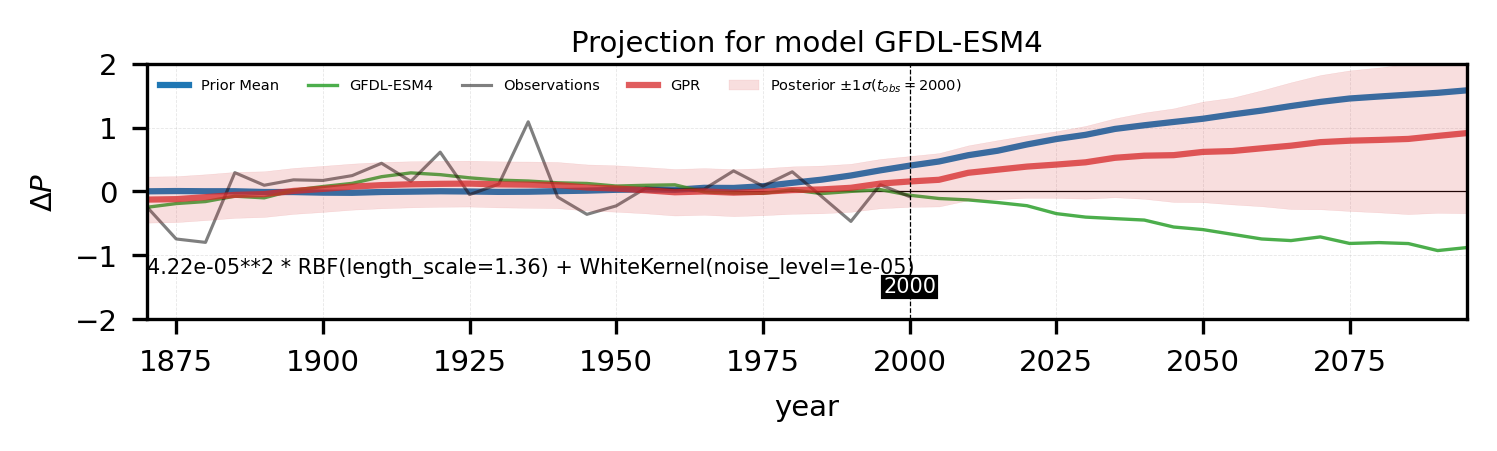

In [5]:
# Location
loc = [20,-5]
models = pr5yr[1]['models'].values
# Selected out of sample model
oosm_index = 19
oos_model = models[oosm_index]
# Define the Kernel
pr_kernel = kernels.ConstantKernel(1, constant_value_bounds=(0, 10)) \
            * kernels.RBF(length_scale=20, length_scale_bounds=(1e-5,100))\
            + kernels.WhiteKernel(.05)

# Define the GPR Model
ugpr_cy = cmip_common_hyparams_ugpr(pr_kernel, pr5yr[1]['pr'].sel(lon=loc[0],lat=loc[1]),\
               pr5yr[0]['pr'].sel(lon=loc[0],lat=loc[1]))

# Train the Model
trainslice = slice(1870,2000)
ugpr_cy.train(trainslice)
print(ugpr_cy.kernel_)
print(ugpr_cy.min_mll)
fitslice = slice(1870,2000)
ugpr_cy.fit(oos_model, fitslice)
# Predict and plot the prediction
ugpr_predicted = ugpr_cy.predict(oos_model)
ugpr_cy.plot_predicted(ugpr_predicted, oos_model, 'nstd')

#### Add more data and predict

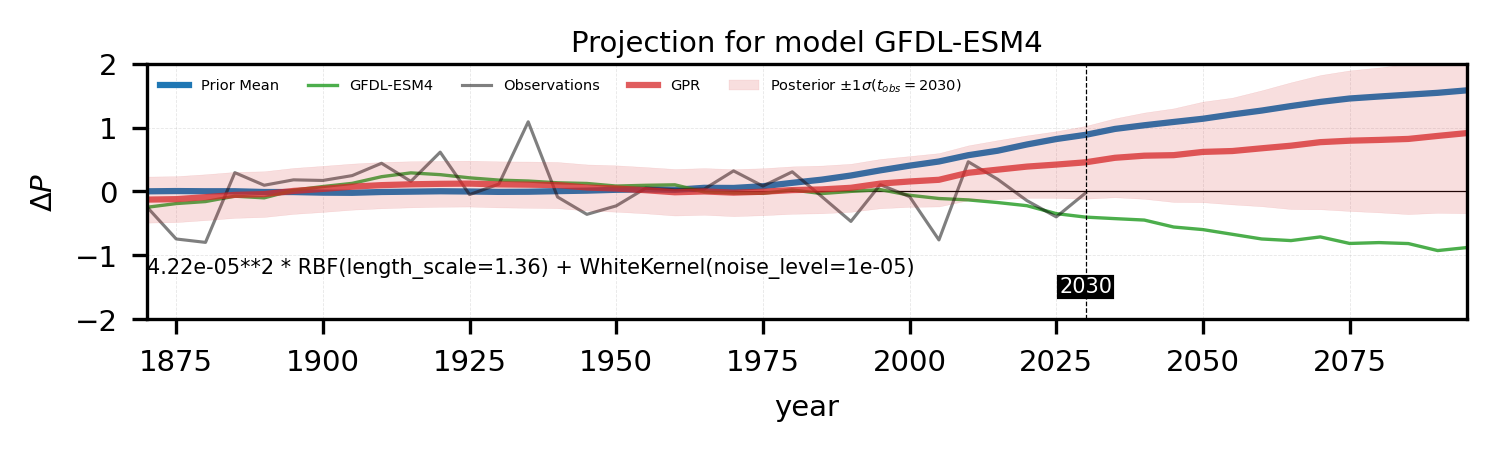

In [9]:
fitslice = slice(1870,2030)
ugpr_cy.fit(oos_model, fitslice)
ugpr_cy.plot_predicted(ugpr_predicted, oos_model, 'nstd')

#### Calculate Emergence

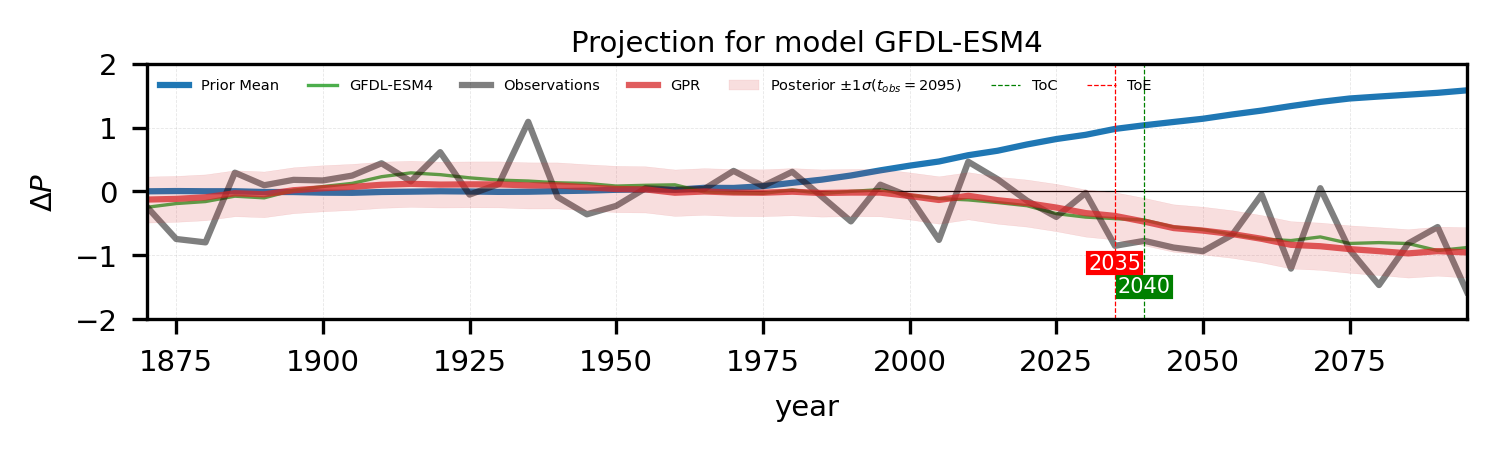

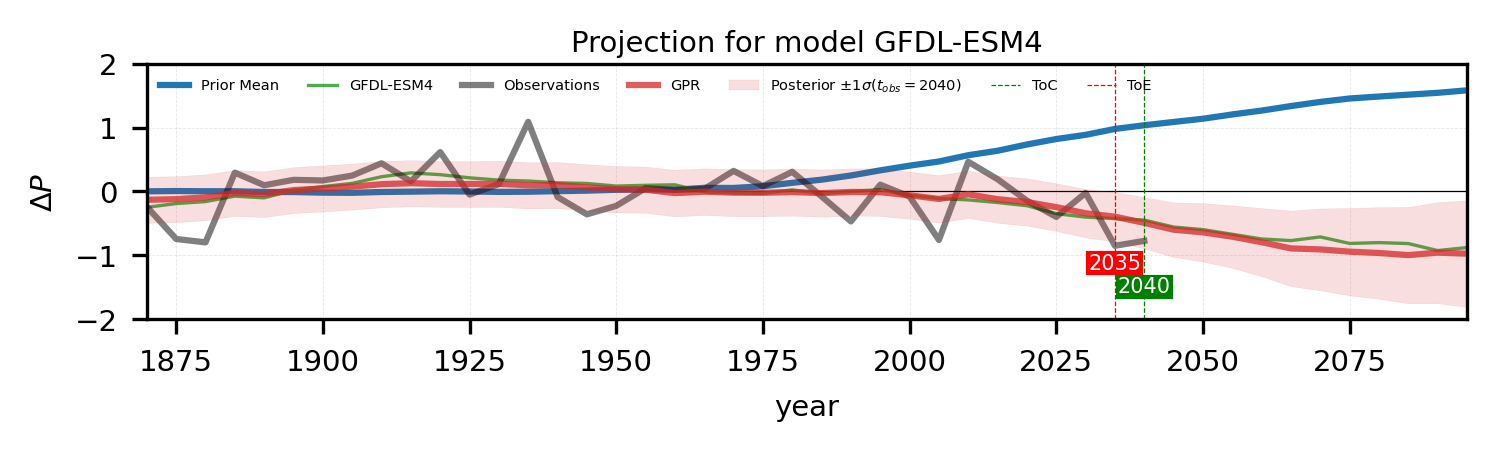

In [7]:
ugpr_cy.calculate_emergence(oos_model,1,.75,'nstd')
ugpr_cy.plot_emergence(oos_model,'nstd')
ugpr_cy.plot_emergence_on_toc(oos_model,'nstd')

### CMIP UGPR with Model Specific Hyperparameters

0.025**2 * RBF(length_scale=1e-05) + WhiteKernel(noise_level=0.0344)
13.710270372004718


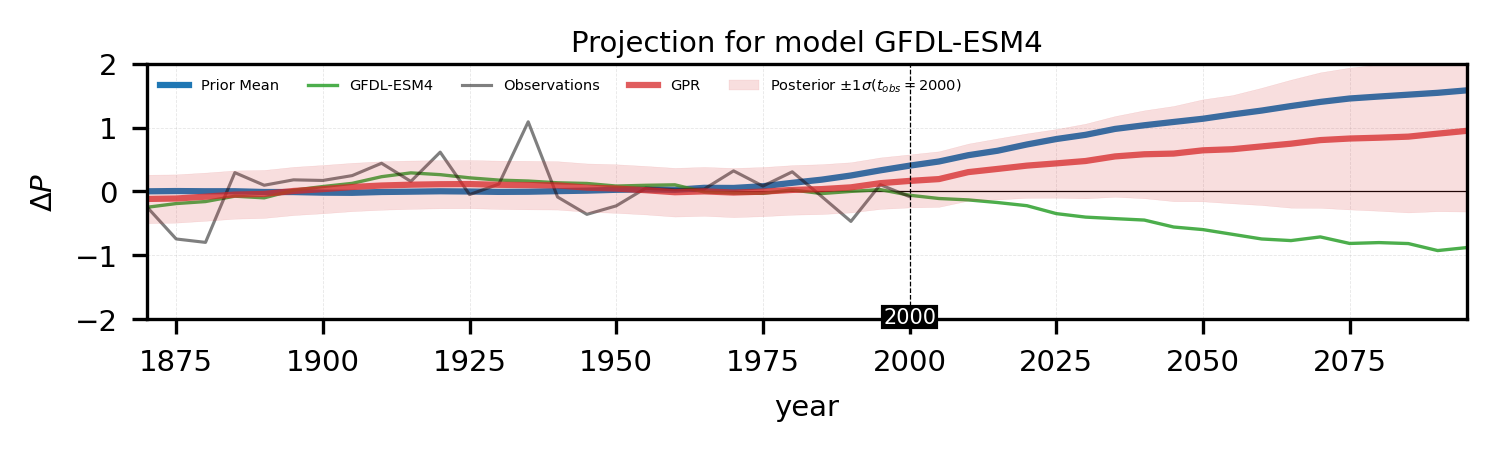

In [8]:
# Location
loc = [20,-5]
models = pr5yr[1]['models'].values
# Selected out of sample model
oosm_index = 19
oos_model = models[oosm_index]
other_gcms = list(set(models)-set({oos_model}))
other_gcms_smoothed = pr5yr[0]['pr'].sel(models=other_gcms,\
                        lon=loc[0],lat=loc[1])
oos_gcm = pr5yr[1]['pr'].sel(models=oos_model,\
                        lon=loc[0],lat=loc[1])
oos_gcm_smoothed = pr5yr[0]['pr'].sel(models=oos_model,\
                        lon=loc[0],lat=loc[1])
# Define the Kernel
pr_kernel = kernels.ConstantKernel(1, constant_value_bounds=(1e-10, 100)) \
            * kernels.RBF(length_scale=10, length_scale_bounds=(1e-5,1e-5))\
            + kernels.WhiteKernel(.5)

# Define the GPR Model
ugpr_ry = cmip_retrained_hyparams_ugpr(pr_kernel, oos_gcm['year'],\
                    oos_gcm, other_gcms_smoothed, oos_gcm_smoothed)

# Train the Model
trainslice = slice(1870,2000)
ugpr_ry.train(trainslice)
print(ugpr_ry.kernel_)
print(ugpr_ry.min_mll)
fitslice = slice(1870,2000)
ugpr_ry.fit(fitslice)
predicted = ugpr_ry.predict()
ugpr_ry.plot_predicted(predicted, oos_model, 'nstd', False)

#### Add more data and make prediction

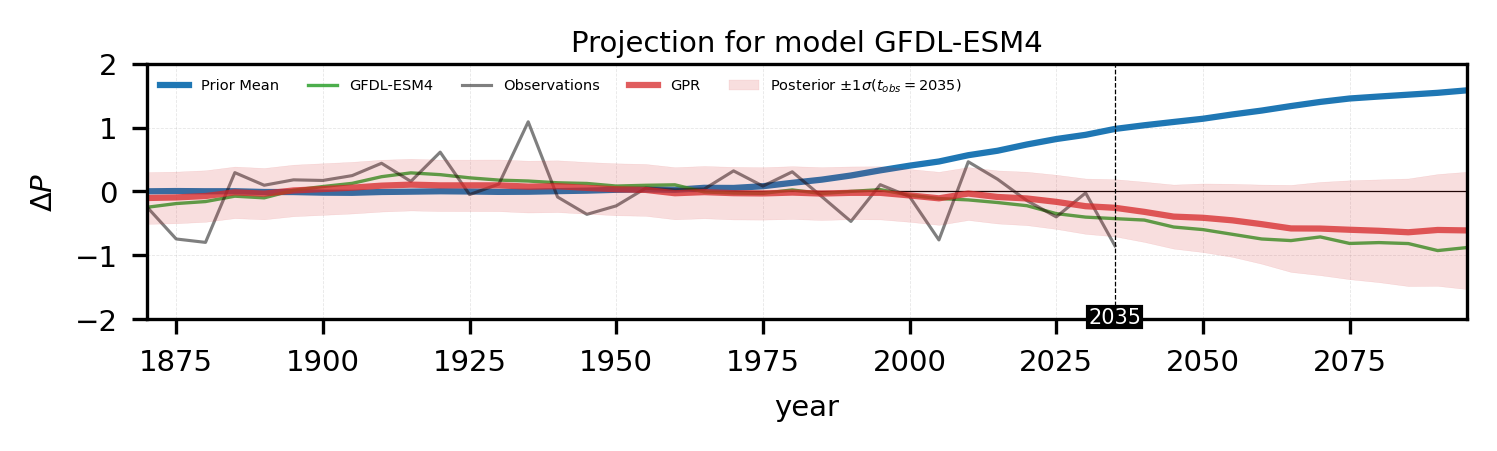

In [9]:
fitslice = slice(1870,2035)
ugpr_ry.fit(fitslice)
predicted = ugpr_ry.predict()
ugpr_ry.plot_predicted(predicted, oos_model, 'nstd', False)

#### Calculate Emergence

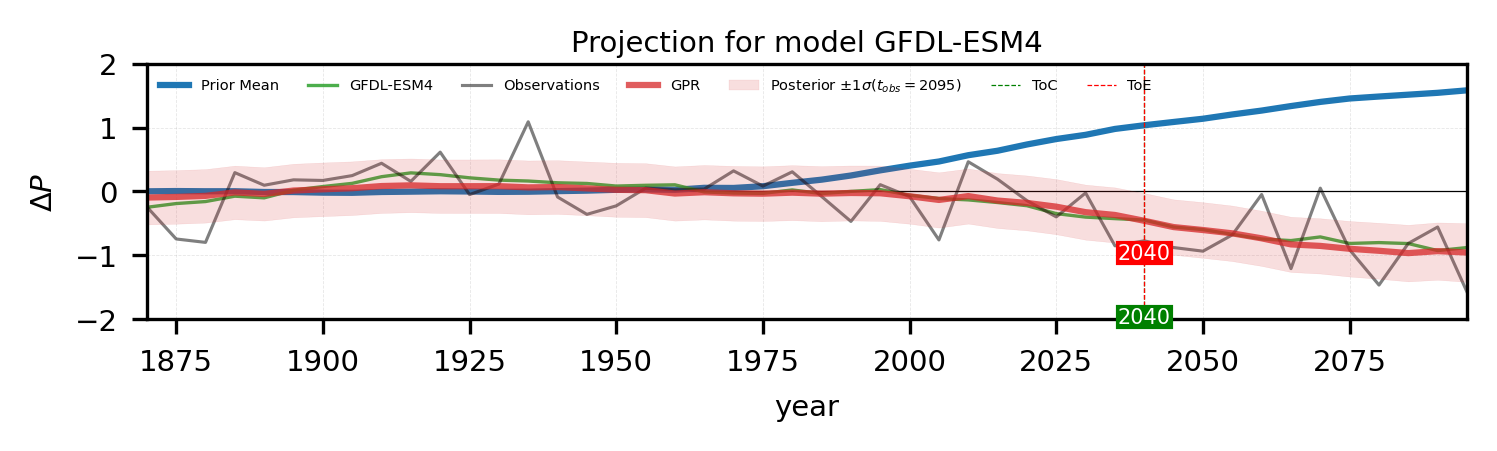

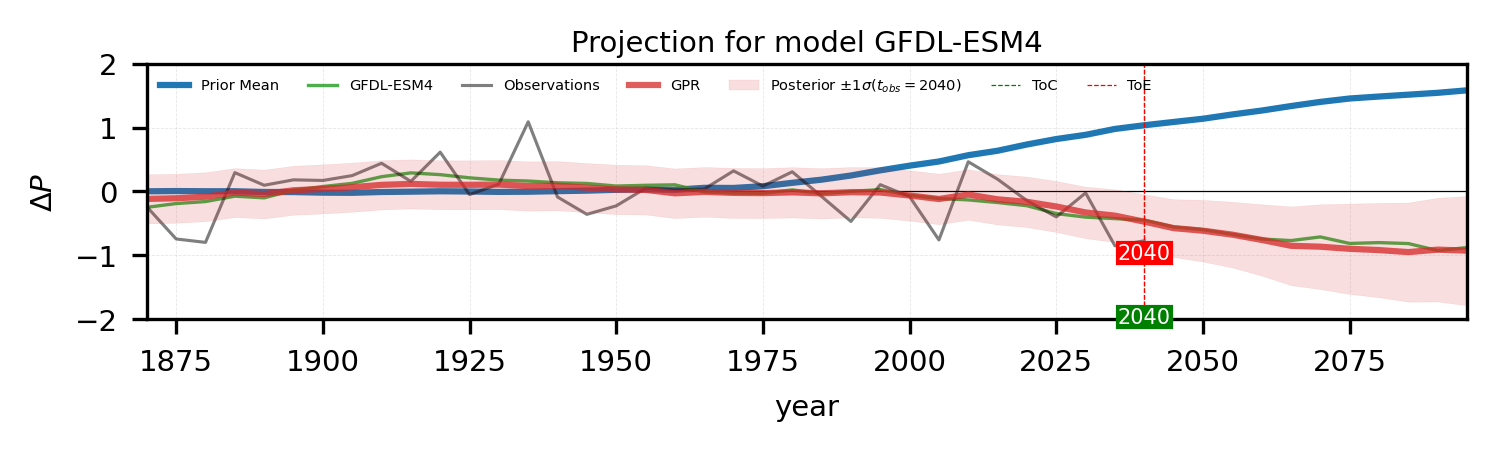

In [12]:
ugpr_ry.calculate_emergence(1,.75,'nstd',optimize=False)
ugpr_ry.plot_emergence(oos_model,'nstd',False)
ugpr_ry.plot_emergence_on_toc(oos_model,'nstd',False)

### CMIP MGPR with Common Hyperparameters

In [ ]:
# Size of the 2D window used
wsize = 11
# Location Used
loc = [180,10]
latslice = slice(loc[1]-wsize,loc[1]+wsize)
lonslice = slice(loc[0]-wsize,loc[0]+wsize)

models = sorted(pr5yr[0]['models'].values)
# Selected out of sample model
oosm_index = 19
oos_model = models[oosm_index]

# The kernel used
pr_kernel = kernels.ConstantKernel(1, constant_value_bounds=(0, 100)) \
            *kernels.Matern(length_scale=[10,5,5],\
            length_scale_bounds=((1e-5,1e5),(1e-5,1e5),(1e-5,1e5)),nu=1.5)\
            + kernels.WhiteKernel(.05)

# Observations
obs = pr5yr[1]['pr'].sel(lat=latslice,lon=lonslice)
# Priors
priors = pr5yr[0]['pr'].sel(lat=latslice,lon=lonslice)

# Define the GPR Model
mgpr_cy = cmip_common_hyparams_mgpr(pr_kernel, obs, priors,\
                                    loc[0], loc[1])
# Train the Model
trainslice = slice(1870,2000)
mgpr_cy.train(trainslice)
print(mgpr_cy.min_mll)
print(mgpr_cy.kernel_)
fitslice = slice(1870,2000)
mgpr_cy.fit(oos_model, fitslice)
mgpr_predicted = mgpr_cy.predict(oos_model)
mgpr_cy.plot_predicted(mgpr_predicted, oos_model, 'nstd')

/Users/an1009/miniconda3/envs/pytor/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:357: RuntimeWarning: divide by zero encountered in log
  return np.log(np.vstack(bounds))


#### Add more data and predict

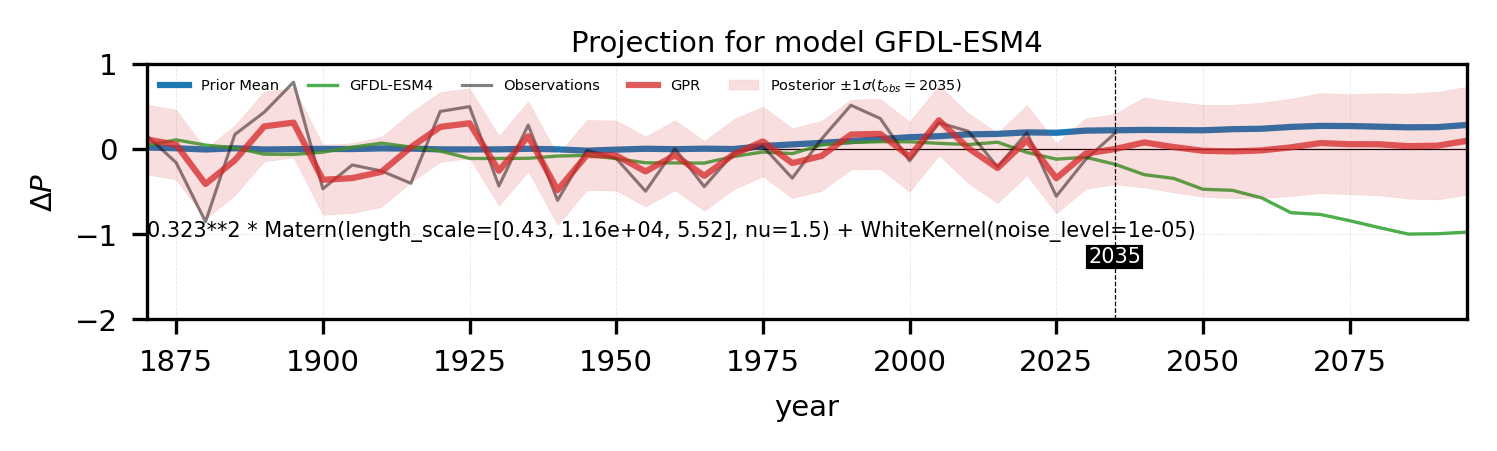

In [15]:
fitslice = slice(1870,2035)
mgpr_cy.fit(oos_model, fitslice)
mgpr_predicted = mgpr_cy.predict(oos_model)
mgpr_cy.plot_predicted(mgpr_predicted, oos_model, 'nstd')

#### Calculate Emergence

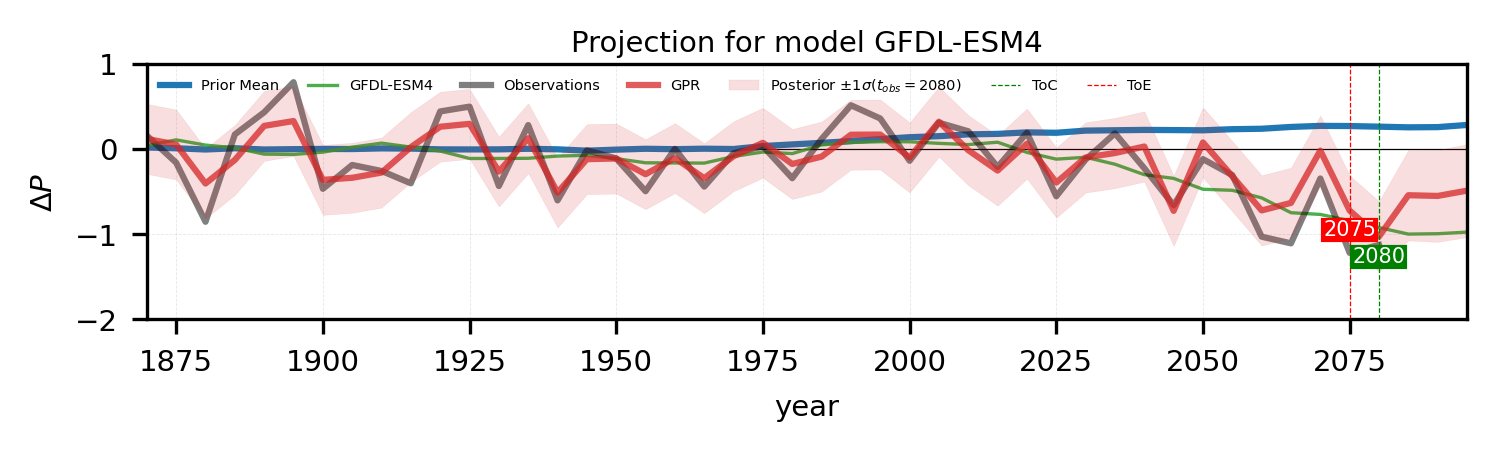

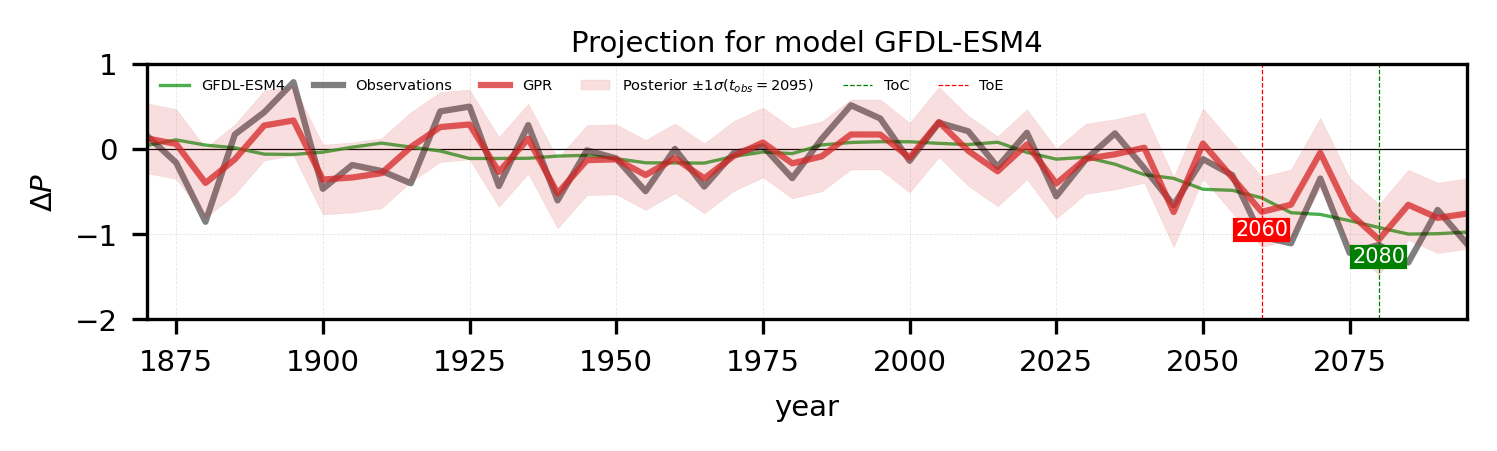

In [16]:
mgpr_cy.calculate_emergence(oos_model,1,.75,'nstd')
mgpr_cy.plot_emergence_on_toc(oos_model, 'nstd', plot_priors=False)
mgpr_cy.plot_emergence(oos_model, 'nstd', plot_priors=False)

### CMIP MGPR with Model Specific Hyperparameters

0.175**2 * Matern(length_scale=[4.46, 1e+05, 1e+05], nu=2.5) + WhiteKernel(noise_level=1e-05)
509.04908000868807
0.175**2 * Matern(length_scale=[4.46, 1e+05, 1e+05], nu=2.5) + WhiteKernel(noise_level=1e-05)
509.04908000868807
0.175**2 * Matern(length_scale=[4.46, 1e+05, 1e+05], nu=2.5) + WhiteKernel(noise_level=1e-05)
509.04908000868807
0.175**2 * Matern(length_scale=[4.46, 1e+05, 1e+05], nu=2.5) + WhiteKernel(noise_level=1e-05)
509.04908000868807
0.175**2 * Matern(length_scale=[4.46, 1e+05, 1e+05], nu=2.5) + WhiteKernel(noise_level=1e-05)
509.04908000868807
0.175**2 * Matern(length_scale=[4.46, 1e+05, 1e+05], nu=2.5) + WhiteKernel(noise_level=1e-05)
509.04908000868807
0.175**2 * Matern(length_scale=[4.46, 1e+05, 1e+05], nu=2.5) + WhiteKernel(noise_level=1e-05)
509.04908000868807
0.175**2 * Matern(length_scale=[4.46, 1e+05, 1e+05], nu=2.5) + WhiteKernel(noise_level=1e-05)
509.04908000868807
3.26 s ± 186 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


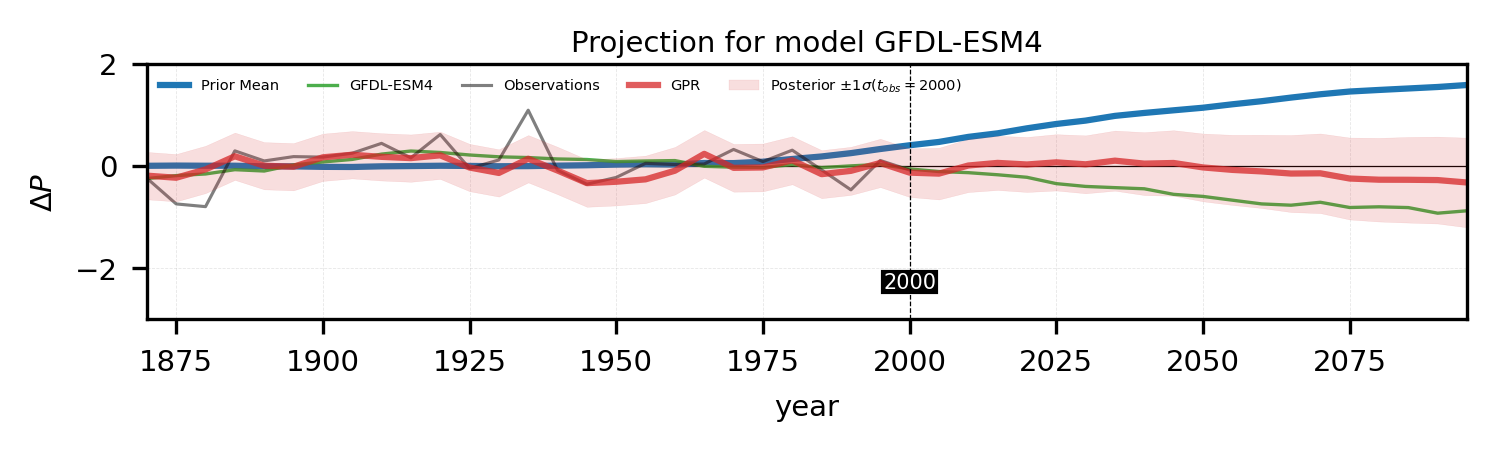

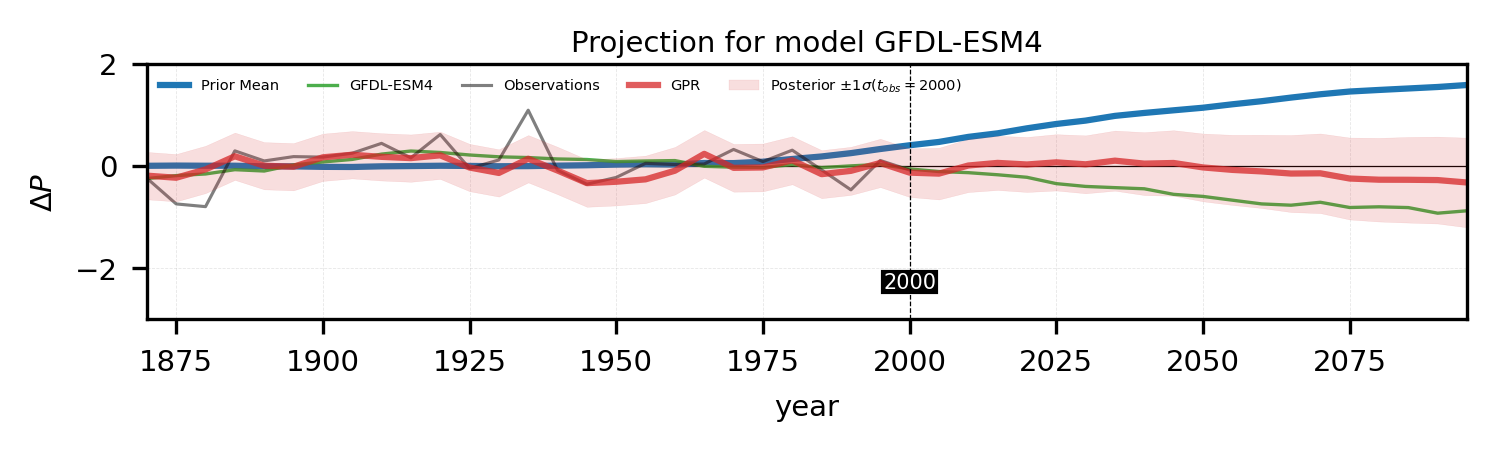

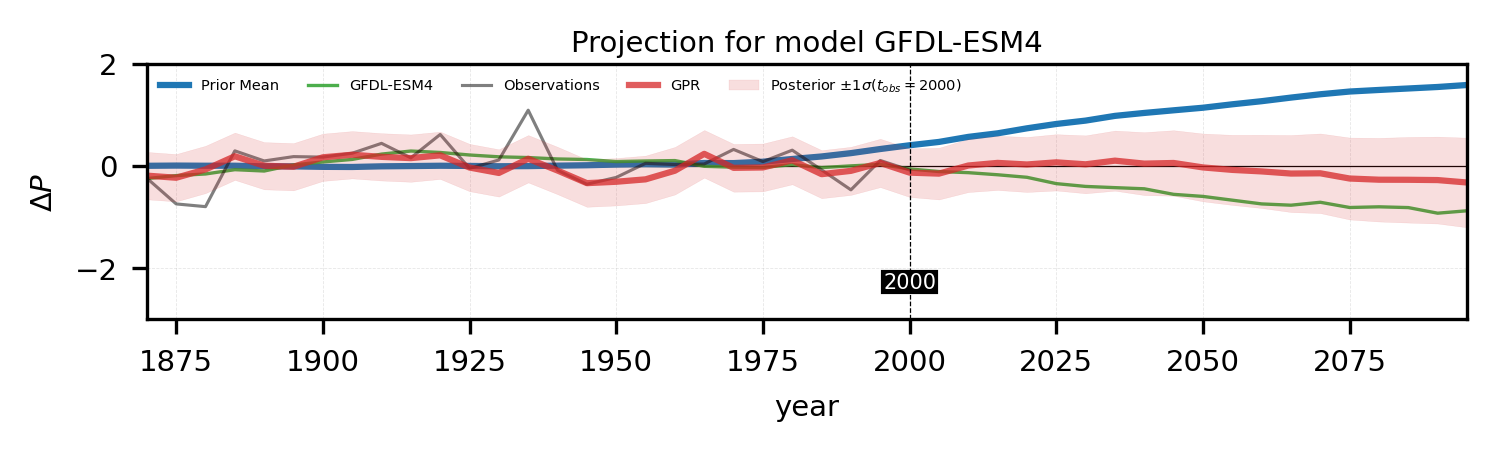

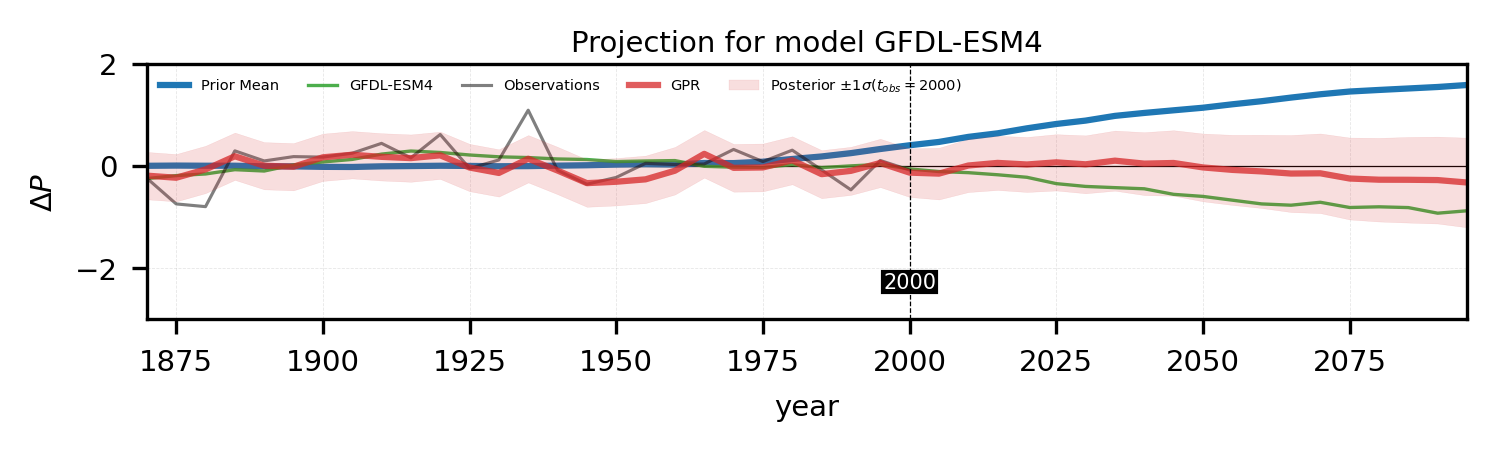

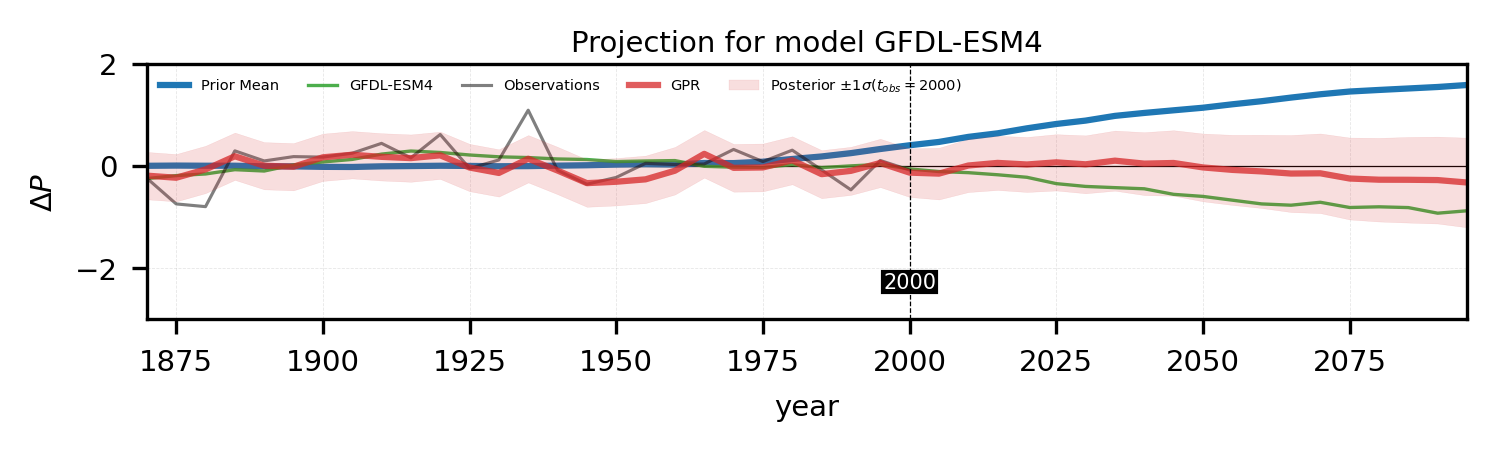

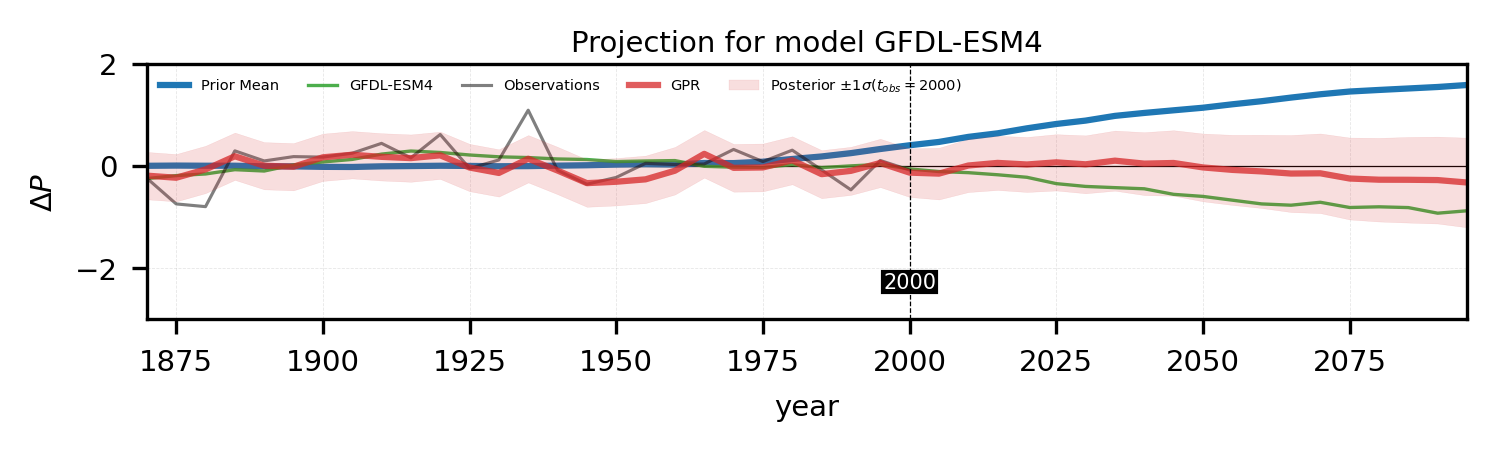

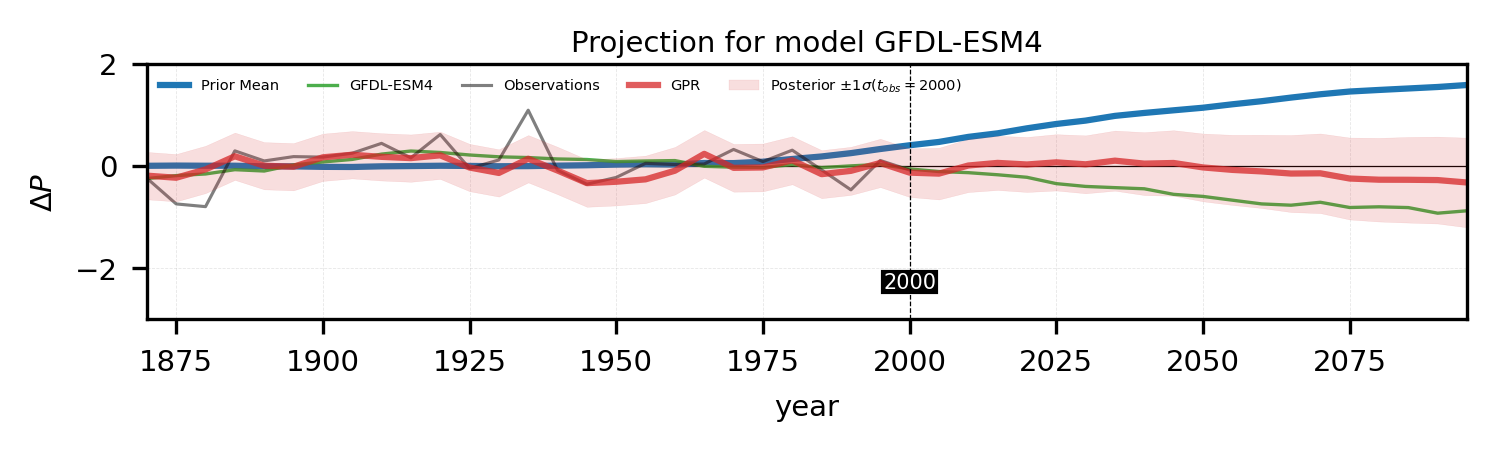

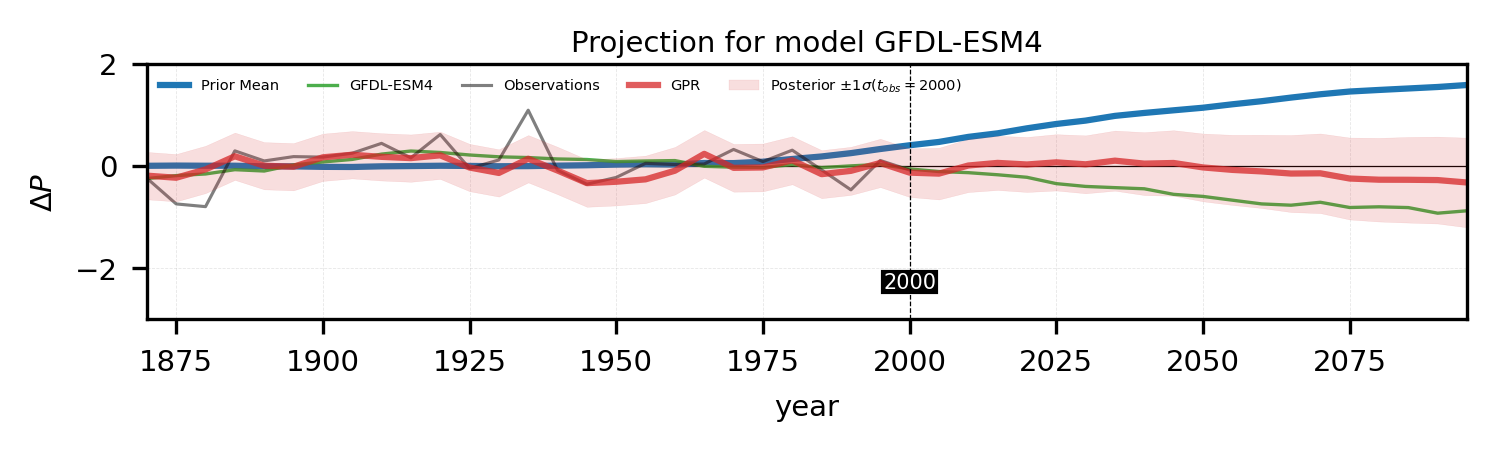

In [18]:
%%timeit
# Size of the 2D window used
wsize = 11
# Location used
loc = [20,-5]
latslice = slice(loc[1]-wsize,loc[1]+wsize)
lonslice = slice(loc[0]-wsize,loc[0]+wsize)
models = sorted(pr5yr[0]['models'].values)
# The out of sample model used
oosm_index = 19
oos_model = models[oosm_index]
oos_gcm = pr5yr[1]['pr'].sel(models=oos_model,\
                        lon=lonslice,lat=latslice)
oos_gcm_smoothed = pr5yr[0]['pr'].sel(models=oos_model,\
                        lon=lonslice,lat=latslice)
# Other GCMs used as priors
other_gcms = list(set(models)-set({oos_model}))
other_gcms_smoothed = pr5yr[0]['pr'].sel(models=other_gcms,\
                        lon=lonslice,lat=latslice)

# The 3D x-values used as predictors
spacetime = oos_gcm.stack(spacetime=['year','lon','lat'])['spacetime']

# The kernel used
pr_kernel = kernels.ConstantKernel(1)* kernels.Matern(length_scale=[1,5,5],\
            length_scale_bounds=((1e-5,1e5),(1e-5,1e5),(1e-5,1e5)),nu=2.5)\
        + kernels.WhiteKernel(.5)
# Define the GPR Model
mgpr_ry = cmip_retrained_hyparams_mgpr(pr_kernel, spacetime, oos_gcm,\
                other_gcms_smoothed, oos_gcm_smoothed, loc[0], loc[1])

# Train the Model
trainslice = slice(1870,2000)
mgpr_ry.train(trainslice)
print(mgpr_ry.kernel_)
print(mgpr_ry.min_mll)
fitslice = slice(1870,2000)
mgpr_ry.fit(fitslice)
predicted = mgpr_ry.predict()
mgpr_ry.plot_predicted(predicted, oos_model, 'nstd', plot_priors=False)

#### Add more data and Predict

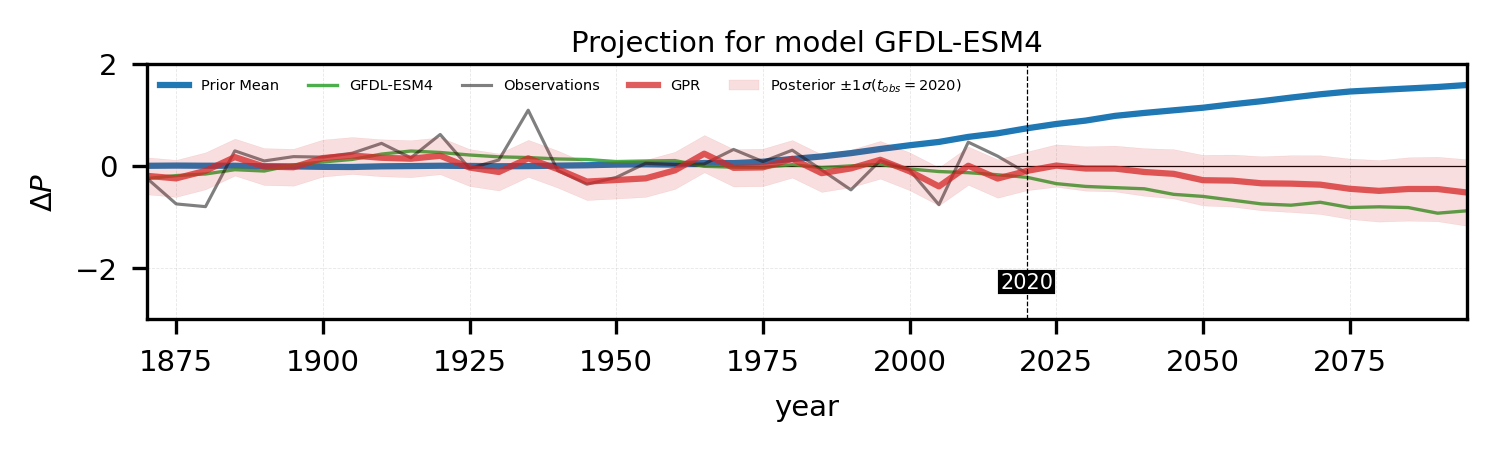

In [11]:
fitslice = slice(1870,2020)
mgpr_ry.fit(fitslice)
predicted = mgpr_ry.predict()
mgpr_ry.plot_predicted(predicted, oos_model, 'std', plot_priors=False)

#### Calculate the Emergence

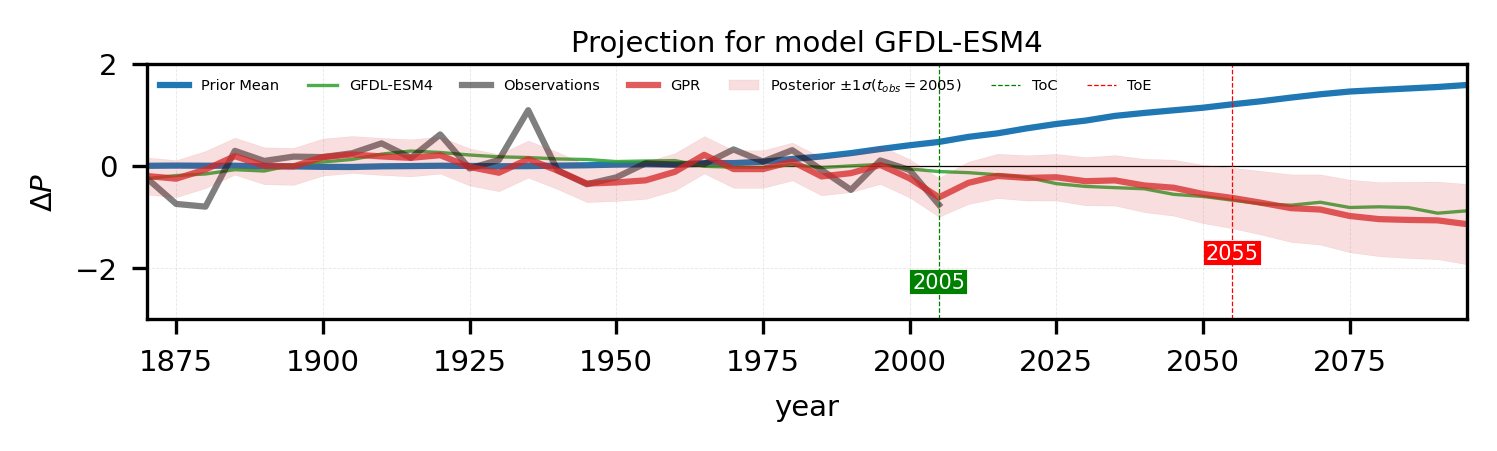

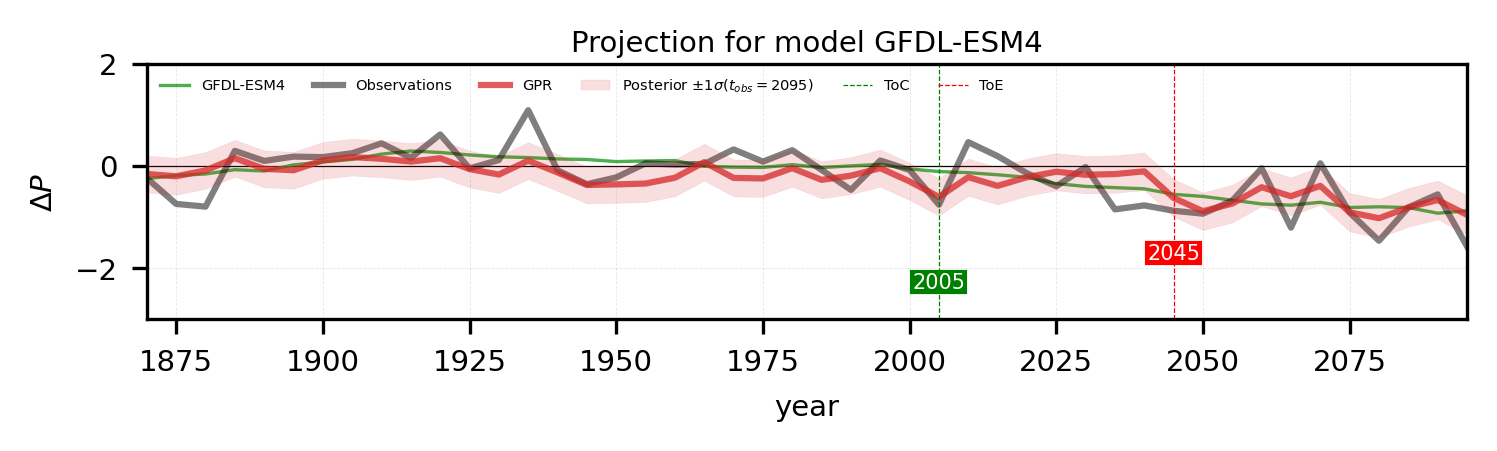

In [12]:
mgpr_ry.calculate_emergence(1,.75,'std',optimize=False)
mgpr_ry.plot_emergence_on_toc(oos_model, 'std', plot_priors=False)
mgpr_ry.plot_emergence(oos_model, 'std', plot_priors=False)